In [1]:
# Workspace problem with several narrow gaps

import torch
import torch.nn as nn

from functools import partial
import numpy as np
from numpy.random import default_rng
from io import StringIO
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import sys
import time
import cv2
from celluloid import Camera
from IPython.display import HTML

sys.path.append('/home/oscar_palfelt/MSc_thesis/ompl/py-bindings')
from ompl import base as ob
from ompl import control as oc
from ompl import geometric as og

rng = default_rng(900)

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")

In [2]:
# load map file

filename = '/home/oscar_palfelt/MSc_thesis/EECS_Degree_Project/learn_control/motion_planning/maps/map_parking.png'
mapImg = cv2.imread(filename, 0)
blurImg = cv2.blur(mapImg, ksize=(3,3))
occGrid = np.clip(mapImg, 0, 1)
inflatedGrid = np.floor(blurImg / 255)

assert occGrid.shape[0] == occGrid.shape[1]
gridSize = occGrid.shape[0]

In [5]:
# define pytorch networks
# based on https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/blob/master/.ipynb_checkpoints/01_Variational_AutoEncoder-checkpoint.ipynb

class Encoder(nn.Module):
    
    def __init__(self, input_dim=X_dim+c_dim, hidden_dim=h_Q_dim, latent_dim=z_dim):
        super(Encoder, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.z_mu = nn.Linear(hidden_dim, latent_dim)
        self.z_logvar = nn.Linear(hidden_dim, latent_dim)
        
    def forward(self, x):

        seq = self.network(x)

        return self.z_mu(seq), self.z_logvar(seq)


class Decoder(nn.Module):
    def __init__(self, latent_dim=z_dim+c_dim, hidden_dim=h_P_dim, output_dim=X_dim):
        super(Decoder, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x):
        
        return self.network(x)


class NeuralNetwork(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(NeuralNetwork, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
    
    def reparameterization(self, mean, logvar):
        epsilon = torch.randn_like(mean).to(DEVICE)        # sampling epsilon        
        z = mean + torch.exp(0.5 * logvar) * epsilon       # reparameterization trick
        return z

    def forward(self, x, c, encode=True):
        if encode:
            z_mu, z_logvar = self.Encoder(torch.cat((x, c), dim=1))
            z = self.reparameterization(z_mu, z_logvar)

            y = self.Decoder(torch.cat((z, c), dim=1))
            
            return y, z_mu, z_logvar
        else:
            z = x
            y = self.Decoder(torch.cat((z, c), dim=1))    

            return y

In [8]:
# neural network parameters
mb_size = 256 # mini batch dim
h_Q_dim = 512*4 # encoder dim
h_P_dim = 512*4 # decoder dim

lr = 1e-4 # learning rate

# problem dimenc_dimsions
nPreviousStates = 1 # number of previous states to condition on the steering prediction
dim = 4 # (x, y, yaw, steer)

z_dim = 1 # latent dim
y_dim = dim # renp.piruction of the original point (unsused?)

nDrawnSamples = 10 # number of dependent samples to draw during smapling (length of predicted control series)
dataElements = (nDrawnSamples + nPreviousStates) * dim + dim - 1

X_dim = nDrawnSamples*dim # steering
c_dim = dataElements - X_dim # dimension of conditioning variable

network_short = torch.load('/home/oscar_palfelt/MSc_thesis/EECS_Degree_Project/learn_control/networks/stateAndCtrl_park_nonscaled_10short.pt')

nDrawnSamples = 20 # number of dependent samples to draw during smapling (length of predicted control series)
dataElements = (nDrawnSamples + nPreviousStates) * dim + dim - 1

X_dim = nDrawnSamples*dim # steering
c_dim = dataElements - X_dim # dimension of conditioning variable

network_long = torch.load('/home/oscar_palfelt/MSc_thesis/EECS_Degree_Project/learn_control/networks/stateAndCtrl_park_nonscaled_20long.pt')

In [10]:
# read in data from .txt file, re-arrange to allow drawing multiple depedent samples

filename = '/home/oscar_palfelt/MSc_thesis/EECS_Degree_Project/learn_control/motion_planning/data/ctrlDataPfollowPark_18000plans'
rawdata = np.genfromtxt(filename, delimiter=',', dtype='d', usecols=[0,1,2,3,7,8,9]) # disregard init

_, pathsIdx = np.unique(rawdata[:,4:], axis=0, return_index=True)
pathsIdx.sort()

pathsLengths = np.roll(pathsIdx, -1) - pathsIdx
pathsLengths[-1] = rawdata.shape[0] - np.sum(pathsLengths[:-1])

validLengthsIdx = np.argwhere(pathsLengths >= nPreviousStates + nDrawnSamples) 
validPlansIdx = pathsIdx[validLengthsIdx]

data = np.zeros(shape=(1, dataElements)) # steering angles, samples (x,y,yaw), goal(x,y,yaw)
tempdata = np.copy(data) # steering angles, samples (x,y,yaw), goal(x,y,yaw)
for ci, i in enumerate(validPlansIdx.reshape(-1)):
    #rawdata[i:i+pathsLenghts[ci], dim-1] = uniform_filter1d(rawdata[i:i+pathsLenghts[ci], dim-1], size=1, origin=0, mode='nearest', axis=0) # average over steering
    for j in range(pathsLengths[ci] - (nPreviousStates + nDrawnSamples - 1)):
        sample = np.arange(start=j, stop=j + nPreviousStates + nDrawnSamples)

        if np.any(np.abs(np.diff(rawdata[i + sample, 0])) > 0.05) or np.any(np.abs(np.diff(rawdata[i + sample, 1])) > 0.05):
            break # ignore duplicate plans (data generation is not perfect)

        tempdata = np.vstack((tempdata, np.append(rawdata[i + sample, :dim].reshape(1, (nPreviousStates + nDrawnSamples)*dim), rawdata[i, dim:].reshape(1, dim-1), axis=1))) 
        if ci % 500 == 0:
            data = np.vstack((data, tempdata[1:]))
            tempdata = np.zeros(shape=(1, dataElements))

rng.shuffle(data) # shuffle data

numEntries = data.shape[0]
print(data.shape)

(84250, 87)


In [11]:
class VehicleState():
    def __init__(self):
        self.x = 0
        self.y = 0
        self.yaw = 0
        self.v = 0

140
saving animation


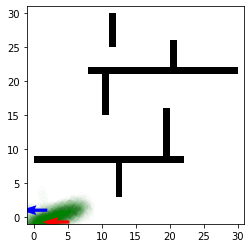

In [52]:
# generate planning scenario, plan, and perform path following

goalDistThreshold = 0.1 # distance to goal when motion execution no longer performed
nLatSamples = 200 # number of samples to draw in latent space (when using nn)
p = 0.8 # likelihood which to sample from NN samples (when useNN is True)
maxCtrlIter = 140

dt = 0.2 # controller time step
L = 0.2 # vehicle length constant
v =  0.1 # vehicle speed

pathIdx = np.random.randint(0, numEntries - 1) # 95321
start = data[pathIdx, :dim]
goal = data[pathIdx, -dim+1:]

start = np.array([29/30, 28/30, -np.pi, 0.])
goal = np.array([2/30, 1/30, -np.pi])

state = VehicleState()

state.x = start[0]; state.y = start[1]; state.yaw = start[2]; state.v = v
statelist = [[state.x, state.y, state.yaw, 0]]

maxSteer = np.max(data[:, 3::dim])
minSteer = np.min(data[:, 3::dim])
steerAngles = np.linspace(minSteer, maxSteer, num=100)
delta = 0

fig = plt.figure()
camera = Camera(fig)

ctrliter = 0
while ctrliter < maxCtrlIter:
    currentState = np.array(statelist[-1])

    c = torch.from_numpy(np.repeat([np.append(currentState, goal)], nLatSamples, axis=0)).float().to(DEVICE)
    if np.linalg.norm(currentState[:-2] - goal[:-1]) < 0.42:
        predictedStates = network_short(torch.randn(nLatSamples, z_dim).to(DEVICE), c, encode=False).cpu().detach().numpy()
    else:
        predictedStates = network_long(torch.randn(nLatSamples, z_dim).to(DEVICE), c, encode=False).cpu().detach().numpy()

    kdes = np.array([gaussian_kde(predictedStates[:, i * dim - 1]) for i in range(1, 2)])
    delta = np.mean(steerAngles[[np.argmax(kde.pdf(steerAngles)) for kde in kdes]])

    plt.scatter(predictedStates[:,::dim] * gridSize, predictedStates[:,1::dim] * gridSize, color='green', s=70, alpha=0.01) # nn samples
    plt.quiver(currentState[0] * gridSize, currentState[1] * gridSize, np.cos(currentState[2]), np.sin(currentState[2]), color='red', scale=8.0, width=0.015)
    plt.quiver(goal[0] * gridSize, goal[1] * gridSize, np. cos(goal[2]), np.sin(goal[2]), color='blue', scale=8.0, width=0.015)
    plt.imshow(mapImg, extent=[0, gridSize, 0, gridSize], cmap='gray')
    plt.xlim([-1, gridSize + 1])
    plt.ylim([-1, gridSize + 1])
    camera.snap()

    state.x += v * np.cos(state.yaw) * dt
    state.y += v * np.sin(state.yaw) * dt
    state.yaw += v / L * np.tan(delta) * dt
    state.v = v - np.clip(np.abs(delta), 0, v / 2)

    statelist.append([state.x, state.y, state.yaw, delta])
    ctrliter += 1
    
    if np.linalg.norm(currentState[:-2] - goal[:-1]) < goalDistThreshold:
        break

print(ctrliter)
animation = camera.animate()
print("saving animation")
animation.save('animation.mp4')

# nSteps = len(statelist)
# statearr = np.array(statelist).reshape(-1).reshape(nSteps, dim)

# fig1 = plt.figure(figsize=(10,6), dpi=80)
# ax1 = fig1.add_subplot(111, aspect='equal')
# ax1.quiver(start[0] * gridSize, start[1] * gridSize, np.cos(start[2]), np.sin(start[2]), color="red", scale=8.0, width=0.015) # init
# ax1.quiver(goal[0] * gridSize, goal[1] * gridSize, np.cos(goal[2]), np.sin(goal[2]), color="blue", scale=8.0, width=0.015) # goal
# ax1.quiver(statearr[:,0] * gridSize, statearr[:,1] * gridSize, np.cos(statearr[:,2]), np.sin(statearr[:,2]), color='purple', scale=16.0, width=0.01)
# ax1.imshow(occGrid, extent=[0, gridSize, 0, gridSize], cmap='gray')




In [32]:
print(goal)

[ 0.579811  0.119888 -2.869749]
